# A first-principles calculation : Nitrogen molecule

Let us go through the fundamentals of simple BigDFT calculation.

The following parameters need to addressed one by one:
- the atomic positions
- the exchange-correlation functional
- the proper converged parameters

For this part of the tutorial, it is interesting to install the full suite, as some calculations can be performed live.

In [ ]:

install = "full_suite" #@param ["full_suite", "client (Google drive)", "client"]
install_var=install
!wget https://gitlab.com/luigigenovese/bigdft-school/-/raw/main/packaging/install.py &> /dev/null
args={'locally': True} if install == 'client' else {}
import install
getattr(install,install_var.split()[0])(**args)

In [ ]:
import install
install.set_ready()

Executing: mkdir -p /content/bigdft-school



In [ ]:
# we need some data to be installed also
install.data('data/session1.tar.xz')

## How to perform a first run 

Atomic positions can be obtained from the BigDFT database (available [here](https://gitlab.com/l_sim/bigdft-suite/-/tree/devel/PyBigDFT/BigDFT/Database/XYZs)).

In [ ]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
from BigDFT.IO import XYZReader

N2 = System()
with XYZReader("N2") as ifile:
    N2["N:0"] = Fragment([next(ifile)])
    N2["N:1"] = Fragment([next(ifile)])

The atomic positions are then

In [ ]:
print(N2.get_posinp())

{'positions': [{'N': [0.0, 0.0, 0.5488], 'frag': ['N', '0']}, {'N': [0.0, 0.0, -0.5488], 'frag': ['N', '1']}], 'units': 'angstroem', 'cell': [inf, inf, inf]}


A calculation is run using the `Calculator` class. 

In [ ]:
from BigDFT import Calculators as C

study = C.SystemCalculator(verbose=True) #Create a calculator
log = study.run(posinp=N2.get_posinp(),name="N2",run_dir='scratch') #run the code

Initialize a Calculator with OMP_NUM_THREADS=1 and command bigdft
Creating the yaml input file "scratch/default.yaml"
Run directory scratch
Executing command:  bigdft -n N2


An instance of the `Logfile` class is returned, containing information about the electronic structure (and more) of the system.

For example, the total energy of the system is

In [ ]:
log.energy #this value is in Ha

-19.884615273242606

Similarly, the eigenvalues and the DoS are obtained as

In [ ]:
log.evals[0].tolist() # the eigenvalues in Ha ([0] stands for the first K-point, here meaningless)

[[-1.041353673208,
  -0.4926440819324,
  -0.4357815638016,
  -0.4357812404171,
  -0.3818323179544]]

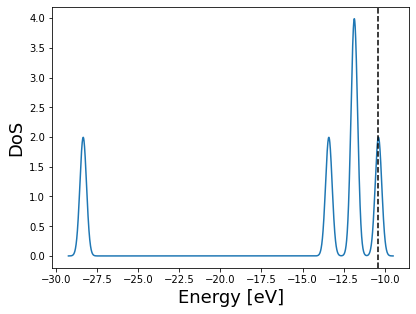

In [ ]:
log.get_dos().plot(); #the density of states

### Calculators

let us look closer at the SystemCalculator that was presented above.

In [ ]:
# we use very little resources asa we are in the cloud.
calc = C.SystemCalculator(verbose=False,omp=2,mpi_run='mpirun --allow-run-as-root -np 1')

This allows to set the computational parameters such as the OpenMP and MPI parallelisations, which is of **crucial importance** for memory and time efficiency. 

**Important**: this tutorial is not representative of the actual time spent in running the code. Here we are using google Colab resources and therfore

The global options of the runner (or calculator) can then be accessed by

In [ ]:
calc.global_options()

{'omp': '2',
 'mpi_run': 'mpirun --allow-run-as-root -np 1',
 'dry_run': False,
 'skip': False,
 'verbose': False}

### RemoteRunner

Note that PyBigDFT also enables to run workflows remotely, as explained in this [tutorial](../tutorials/RemoteRunner.ipynb).

## How to modify the input parameters

To specify non-default input parameters to the code, we should employ a `Inputfile` object.

For instance, the XC functional can be chosen via the `set_xc` method.
All methods are accessible [here](https://l_sim.gitlab.io/bigdft-suite/PyBigDFT/build/html/BigDFT.InputActions.html)

In [ ]:
from BigDFT import Inputfiles as I

inp = I.Inputfile()
inp.set_xc('LDA')

In the same spirit, a Hartree-Fock calculation is performed using.

In [ ]:
inp.set_xc('HF')
HF = study.run(name="HF",input=inp,run_dir='scratch') #Run the code with the name scheme HF

Creating the yaml input file "scratch/HF.yaml"
Run directory scratch
Executing command:  bigdft -n HF
ERROR: some problem occured during the execution of the command, check the 'debug/' directory and the logfile
The error occured is BIGDFT_INPUT_FILE_ERROR
Additional Info:  The pseudopotential parameter file "psppar.N" is lacking, and no registered pseudo found for "N"


An **error** occurred !

Let us identify the issue by opening [debug/bigdft-err-0.yaml](./debug/bigdft-err-0.yaml)

<pre>
 Additional Info:
   The pseudopotential parameter file "psppar.N" is lacking, and no registered pseudo found 
   for "N"</pre>
   
The issue is that the pseudopotential is assigned by default in the code **only for LDA and PBE** XC approximations.

Therefore, one simply needs to specify it.

In [ ]:
inp['psppar.N']={'Pseudopotential XC': 1} #here 1 stands for LDA as per the XC codes
study.update_global_options(skip=True) #if a finalized calculation is found in scratch, the calculation is not performed
HF = study.run(name="HF",input=inp,run_dir='scratch')

Creating the yaml input file "scratch/HF.yaml"
Run directory scratch
Executing command:  bigdft -n HF -s Yes


One should be careful in **choosing a pseudopotential** which has been **generated with the same XC approximation** used. 

At present, Hartwigsen-Goedeker-Hutter (HGH) data are unfortunately only available for semilocal functionals. For example, the same exercise as follows could have been done with Hybrid XC functionals (e.g. PBE0 (ixc=-406)). 

In the case of Hartree-Fock calculations, using semilocal functionals generally yield accurate results (see [Physical Review B 37.5 (1988): 2674](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.37.2674)). 

In BigDFT, XC functionals are specified using the built in named functionals, or using the [LibXC codes](https://www.tddft.org/programs/libxc/functionals/).

## How to perform a convergence analysis

Daubechies Wavelets is a systematic basis set (as plane waves are), where accuracy is arbitrarily increased by varying some parameters, i.e. (typically) `hgrid` and `rmult`.

**`hgrids`**
      set up the grid step for the basis set spatial expansion. There is **one float value** describing the grid         steps in the three space directions (i.e. $x$, $y$ and $z$) or a **3D array** is also accepted.
      These values are in bohr unit and typically range from 0.3 to 0.65. 
      The harder the pseudo-potential, the lower value should be set up.
      These values are set using the `set_hgrid` method of the `Inpufile` class.
        
**`rmult`**
      set up the basis set spatial expansion. It contains an array of two float values that are **two multiplying       factors** defining chemical-species-dependent quantities.
      The first factor is the most important since it describes the spatial expansion of the basis set, defined as       a set of real space points with non-zero values inside spheres centered on atoms.
      The first multiplying factor is called `crmult` for Coarse grid Radius MULTiplier, with typical values of 5       to 7.
      The second one called `frmult` for Fine grid Radius MULTiplier is related to the fine resolution.
      This parameter is less pertinent for the convergence of energy and can be ignored.
      It is possible to indicate only one float value, the `crmult` parameter.
      Such parameters can be set by the method `set_rmult` of `Inputfile` class.

Let us find the appropriate parameters to characterize a N2 molecule using the `Dataset`class, by comparing the extracted energies depending on `hgrid` and `rmult`.

In [ ]:
hgrids = [0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2] #bohr
rmult = [3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

Let us build three different datasets, by varying:
- `hgrid` and `rmult` together. 
- only `hgrid`
- only `rmult`

Each input dictionary is also labeled by a unique name.

In [ ]:
from BigDFT import Datasets as D
from copy import deepcopy

inp = I.Inputfile()
pos = N2.get_posinp()
study = C.SystemCalculator(verbose=True, skip=True) #to avoid long waiting time

h_and_c_dataset = D.Dataset('h_and_c')
for h,c in zip(hgrids,rmult):
    inp_run = deepcopy(inp) # to avoid modifications of `inp`
    inp_run.set_hgrid(h)
    inp_run.set_rmult([c,9.0])
    h_and_c_dataset.append_run(id={'h':h,'c':c},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

Initialize a Calculator with OMP_NUM_THREADS=1 and command bigdft


In [ ]:
h_only_dataset = D.Dataset('h_only')
for h in hgrids:
    inp_run = deepcopy(inp)
    inp_run.set_hgrid(h)
    h_only_dataset.append_run(id={'h':h},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

In [ ]:
c_only_dataset = D.Dataset('c_only')
for c in rmult:
    inp_run = deepcopy(inp)
    inp_run.set_rmult([c,9.0])
    c_only_dataset.append_run(id={'c':c},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

Each dataset is then ran. This cell, when executed with the full_suite, should take about 6-7 minutes to complete. While this is running, you can proceed with the following tutorial which can be executed in `dry_run` scheme (namely without actually running the computations).

In [ ]:
h_only_dataset.run()
c_only_dataset.run()
h_and_c_dataset.run()

Creating the yaml input file "scratch/h__0.55.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.55 -s Yes
Creating the yaml input file "scratch/h__0.5.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.5 -s Yes
Creating the yaml input file "scratch/h__0.45.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.45 -s Yes
Creating the yaml input file "scratch/h__0.4.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.4 -s Yes
Creating the yaml input file "scratch/h__0.35.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.35 -s Yes
Creating the yaml input file "scratch/h__0.3.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.3 -s Yes
Creating the yaml input file "scratch/h__0.25.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.25 -s Yes
Creating the yaml input file "scratch/h__0.2.yaml"
Run directory scratch
Executing command:  bigdft -n h__0.2 -s Yes
Creating the yaml input file "scratch/c__3.5.yaml"
Run d

{0: <BigDFT.Logfiles.Logfile at 0x7f9796ec4ed0>,
 1: <BigDFT.Logfiles.Logfile at 0x7f9796cb6cd0>,
 2: <BigDFT.Logfiles.Logfile at 0x7f9796d4e710>,
 3: <BigDFT.Logfiles.Logfile at 0x7f9796bcfa90>,
 4: <BigDFT.Logfiles.Logfile at 0x7f97995db050>,
 5: <BigDFT.Logfiles.Logfile at 0x7f9796ee4590>,
 6: <BigDFT.Logfiles.Logfile at 0x7f9796bbf110>,
 7: <BigDFT.Logfiles.Logfile at 0x7f9796c0dad0>}

We now store the energies of each of the dataset runs, and identify the minimum as the minimum value from the `h_and_c` dataset:

In [ ]:
from numpy import array

energies_h = array(h_only_dataset.fetch_results(attribute='energy'))
energies_c = array(c_only_dataset.fetch_results(attribute='energy'))
energies_hc = array(h_and_c_dataset.fetch_results(attribute='energy'))
#find the minimum and subtract (do you understand numpy syntax? Otherwise don't be afraid to ask...)
emin = min(energies_hc)
h_data=energies_h-emin
c_data=energies_c-emin
h_and_c_data=energies_hc-emin

We plot the energy values varying the grid spacing or the wavelet extension

In [ ]:
h_and_c_dataset.ids

[{'h': 0.55, 'c': 3.5},
 {'h': 0.5, 'c': 4.0},
 {'h': 0.45, 'c': 4.5},
 {'h': 0.4, 'c': 5.0},
 {'h': 0.35, 'c': 5.5},
 {'h': 0.3, 'c': 6.0},
 {'h': 0.25, 'c': 6.5},
 {'h': 0.2, 'c': 7.0}]

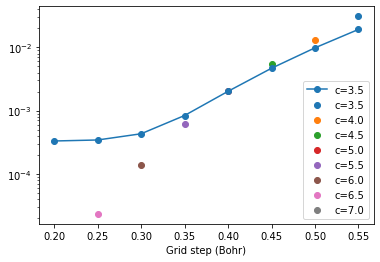

In [ ]:
import matplotlib.pyplot as plt

plt.xlabel('Grid step (Bohr)')
plt.yscale('log')
plt.plot(hgrids,h_data,label='c=3.5',marker='o',linestyle='solid')
for dt,e in zip(h_and_c_dataset.ids,h_and_c_data):
    x=dt['h']
    plt.scatter(x,e,label='c='+str(dt['c']))
plt.legend(loc='best');

Likewise, we plot the energy values for the grid spacing

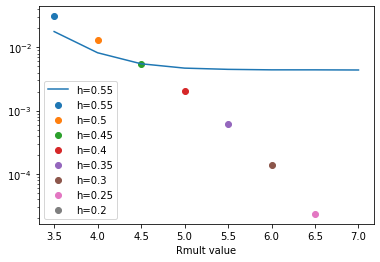

In [ ]:
plt.xlabel('Rmult value')
plt.plot(rmult,c_data,label='h=0.55')
for dt,e in zip(h_and_c_dataset.ids,h_and_c_data):
    x=dt['c']
    plt.scatter(x,e,label='h='+str(dt['h']))
plt.yscale('log')
plt.legend(loc='best');

Importantly, both hgrids and rmult have to be decreased and increased (respectively) in order to achieve convergence. Increasing only one of the two parameter will eventually lead to **saturation of the absolute error** on the energy.

### Exercise on XC functional

Compare the values of the HOMO and HOMO-1 eigenvalues for the LDA, PBE, HF and PBE0 functionals. The corresponding outputs are already available in the directory `scratch`, therefore you may run them in skip mode.

The calculation were run with `hgrid=.3` and `rmult=6` using the `Dataset` class, as detailed below.  

**Hint**: the attributes of a `Logfile` object are listed [here](https://l_sim.gitlab.io/bigdft-suite/PyBigDFT/build/html/_modules/BigDFT/Logfiles.html#get_logs). The followin totorial will also explain some tips.

In [ ]:
xc_list = ['LDA','PBE','HF','PBE0']

In [ ]:
from BigDFT import Datasets as D

inp = I.Inputfile()
inp.set_hgrid(.3)
inp.set_rmult(6)
pos = N2.get_posinp()
study = C.SystemCalculator(skip=True,verbose=True)

xc_dataset = D.Dataset('xc')
for xc in xc_list:
    inp_run = deepcopy(inp)
    inp_run.set_xc(xc)
    if xc in ['HF','PBE0']:
        inp_run['psppar.N']={'Pseudopotential XC': 1} 
    xc_dataset.append_run(id={'xc':xc},run_dir='scratch',input=inp_run,posinp=pos,runner=study)

Initialize a Calculator with OMP_NUM_THREADS=1 and command bigdft


In [ ]:
xc_dataset.run() #if you run this in skip=False mode you'll need about 6 minutes in Colab cloud resources.

Creating the yaml input file "scratch/xc__LDA.yaml"
Run directory scratch
Executing command:  bigdft -n xc__LDA -s Yes
Creating the yaml input file "scratch/xc__PBE.yaml"
Run directory scratch
Executing command:  bigdft -n xc__PBE -s Yes
Creating the yaml input file "scratch/xc__HF.yaml"
Run directory scratch
Executing command:  bigdft -n xc__HF -s Yes
Creating the yaml input file "scratch/xc__PBE0.yaml"
Run directory scratch
Executing command:  bigdft -n xc__PBE0 -s Yes


{0: <BigDFT.Logfiles.Logfile at 0x7f9796cd3a90>,
 1: <BigDFT.Logfiles.Logfile at 0x7f9796d97610>,
 2: <BigDFT.Logfiles.Logfile at 0x7f9796d92e50>,
 3: <BigDFT.Logfiles.Logfile at 0x7f9796d92b10>}

### Solution

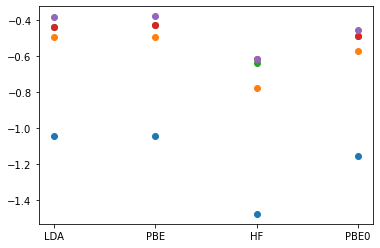

In [ ]:
from numpy import array
#this is a qlick look at the difference in evals, possible because we have very few orbitals
evals = array(xc_dataset.fetch_results(attribute='evals'))

plt.plot(xc_list,evals[:,0,0,:],'o');

## Exercise (summary)

1) Compare other attributes of the `Logfile` instance of N2, such as the energy contributions (Hartree, ions, XC, ...), depending on the XC functional

2) Compare the convergence characteristics (`hgrid` and `rmult`) of N2 depending on the XC functional (semilocal vs non-local)

3) Compute the dissociation energies of CH4 (data [here](https://aip.scitation.org/doi/10.1063/1.469843)) (**Advanced**)